In [1]:
import torch
import torch.nn as nn
import tiktoken

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [8]:
import matplotlib.pyplot as plt

In [ ]:
# from utils.gpt import GPTModel
# from utils.gptdataset import GPTDatasetV1, create_dataloader_v1
# from utils.loss import calc_loss_batch, calc_loss_loader

# from utils.generator import generate_text_simple
# from utils.conversion import text_to_token_ids, token_ids_to_text

Previously, inside the `generate_text_simple` function, we always sampled the token with the highest probability as the next token using `torch.argmax`, also known as greedy decoding. To generate text with more variety, we can replace **argmax** with a function that **samples from a probability distribution**.

### Illustration of probabilistic sampling

In [2]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

Next, assume the LLM is given the start context "every effort moves you" and generates the following next-token logits:

In [3]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

Inside `generate_text_simple`, we convert the logits into probabilities via the softmax function and obtain the token ID corresponding to the generated token via the argmax function, which we can then map back into text via the inverse vocabulary:

In [4]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


Since the largest logit value and, correspondingly, the largest softmax probability
score are in the fourth position (index position 3 since Python uses 0 indexing), the
generated word is "forward"

To implement a probabilistic sampling process, we can now replace `argmax` with
the `multinomial` function in PyTorch:

In [5]:
# torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


The printed output is `"forward"` just like before. What happened? The `multinomial`
function samples the next token proportional to its probability score. In other words,
`"forward"` is still the most likely token and will be selected by `multinomial` most of
the time but not all the time. To illustrate this, let’s implement a function that repeats
this sampling 1,000 times:

In [6]:
def print_sampled_tokens(probas):
    
    torch.manual_seed(123)
    
    # Generate 1,000 samples from the probability distribution 'probas'
    # torch.multinomial samples indices based on probabilities in 'probas'
    # num_samples=1 means one sample per iteration; .item() extracts the scalar value
    sample = [torch.multinomial(probas, num_samples=1).item()
                    for i in range(1_000)]

    '''
    For example, if probas = [0.7, 0.2, 0.1], 
    index 0 has a 70% chance of being sampled, index 1 has 20%, and index 2 has 10%. 
    '''

    # Count frequency of each sampled index using torch.bincount
    # Converts the list of samples into a tensor and counts occurrences of each index
    sampled_ids = torch.bincount(torch.tensor(sample))

    '''
    torch.bincount: Counts the occurrences of each integer in the sampled list. 
    For example, if sample = [0, 1, 0, 2], torch.bincount returns a tensor like [2, 1, 1], 
    indicating index 0 appeared twice, index 1 once, and index 2 once. 
    '''

    # Iterate over the frequency counts and print each token's frequency
    # inverse_vocab[i] maps the index i to its corresponding token

    for i, freq in enumerate(sampled_ids):
        print(f"{freq}  x  {inverse_vocab[i]}")

print_sampled_tokens(probas)

71  x  closer
2  x  every
0  x  effort
544  x  forward
2  x  inches
1  x  moves
0  x  pizza
376  x  toward
4  x  you


As we can see, the word forward is sampled most of the time (544 out of 1,000 times), but other tokens such as closer, inches, and toward will also be sampled some of the time. 

This means that if we replaced the argmax function with the multinomial function inside the `generate_and_print_sample` function, the LLM would sometimes generate texts such as *every effort moves you toward*, *every effort moves you inches*, and *every effort moves you closer* instead of *every effort moves you forward*.

## Temperature Scaling

Temperature scaling is just a fancy description for dividing the logits
by a number greater than 0

Why is it called **"temperature"**?

This is attributed to it's relation with entropy (increased randomness of generated token) as illustrated below:

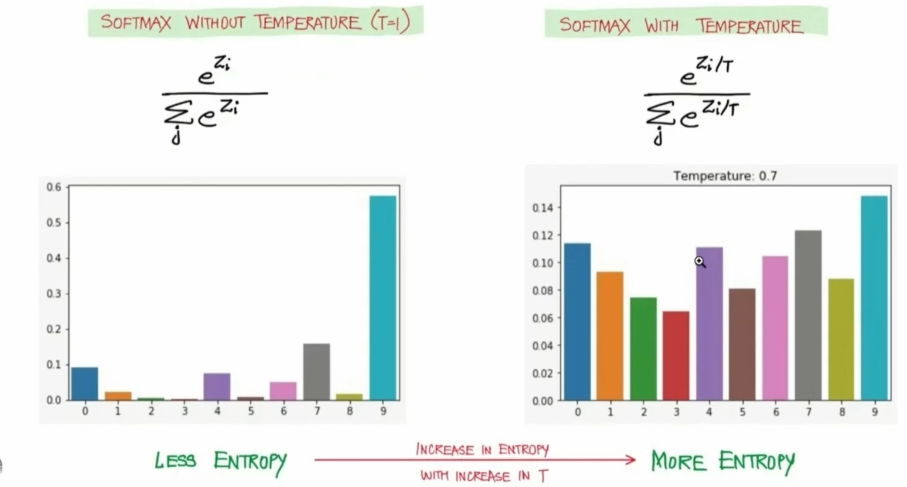



In [7]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

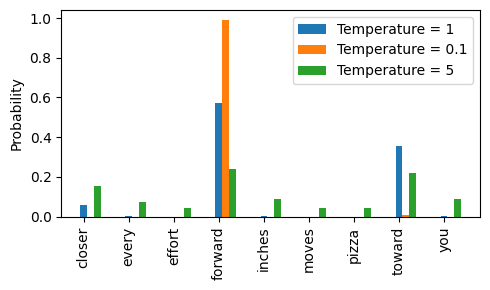

In [9]:
temperatures = [1, 0.1, 5] 

scaled_probas = [softmax_with_temperature(next_token_logits, T)
    for T in temperatures]

x = torch.arange(len(vocab))

bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))

for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
    bar_width, label=f'Temperature = {T}')
    
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

Applying very small temperatures, such as $0.1$, will result in sharper distributions such that the behavior of the multinomial function selects the most likely token (here, "forward") almost 100% of the time, approaching the behavior of the `argmax` function. 

Likewise, a temperature of 5 results in a more uniform distribution where other tokens are selected more often. This can add more variety to the generated texts but also more often results in nonsensical text.

Using temperature scaling with multinomial sampling follows a process:

Logits -> Scaled logits (temperature) -> Softmax -> Multinomial sampling

### Top-k sampling

The higher temperature values allow for the exploring of less likely but potentially more interesting and creative paths in the generation process.

However, one downside of this approach is that it sometimes leads to grammatically incorrect or completely nonsensical outputs such as *every effort moves you pizza*

So, we want to keep mmultinomial sampling but sample from those tokens which have high probabilities.

The top-k approach replaces all nonselected logits with negative infinity value (-inf) such that when computing the softmax values, the probability scores of the non-top-k tokens are 0, and the remaining probabilities sum up to 1.

This process is similar to the masking trick from causal attention.

We utilize pytorch's `topk` method

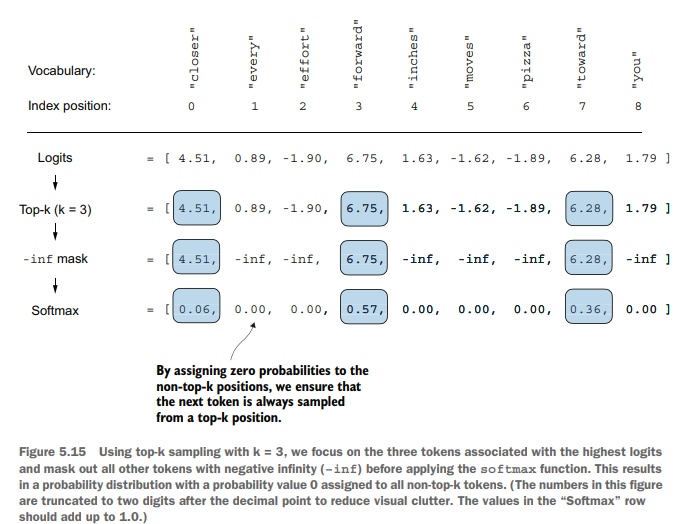

In [ ]:
print(next_token_logits)
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos) # Indexes of the top logits in the original tensor


tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])
Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch’s where function to set the logit values of tokens that are
below the lowest logit value within our top-three selection to negative infinity (-inf):

In [13]:
new_logits = torch.where(
 condition=next_token_logits < top_logits[-1], 
 input=torch.tensor(float('-inf')), 
 other=next_token_logits 
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [14]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Merging temperature and top-k methods

We will now modify the `generate_text_simple()` method as follows:

1. After obtaining the **logits** from the GPT model, first apply pytorch's `topk` method to obtain the **top-k logits**

2. Apply a mask to convert all logits lesser than the minimum of the top-k logits to (-inf)

3. Divide the logits by `temperature` value (temperature scaling) and then apply the `softmax` function to get the probabilities.

4. Finally sample the next token index using `multinomial` method (sampling from the multinomial distribution).

In [15]:
def generate(model, idx, max_new_tokens, context_size,
             temperature = 0.0, top_k = None, eos_id = None):
    """
    Generate text iteratively using the model applying temperature scaling, 
    top-k sampling and multinomial sampling until:
    number of iterations = max_new_tokens.
    """
    # Here, model is an instance of GPTModel. 
    # idx is the input text tokenized and converted to tensor
    # and max_new_tokens is the number of tokens to generate.
    # and context_size is the size of the context window (how many tokens model has to process).

    # idx example:
    # tensor([[6109, 3626, 6100,  345],
        # [6109, 1110, 6622,  257]])
    
    # idx shape = (batch, n_tokens)
    
    for _ in range(max_new_tokens):

        '''
        Crops current context if it exceeds the supported context size, 
        e.g., if LLM supports only 5 tokens, and the context size is 10, 
        then only the last 5 tokens are used as context 
        '''
        idx_cond = idx[:, -context_size:]
        # idx_cond is the last context_size tokens of idx
        # idx_cond example:
        '''
        idx = tensor([[10, 23, 45, 67, 89, 123, 56, 78], # First sequence/batch
                    [9, 8, 7, 6, 5, 4, 3, 2]]) # Second sequence/batch
        
        If context_size = 6 then:
        idx_cond = tensor([[45, 67, 89, 123, 56, 78], # First sequence/batch
                           [6, 5, 4, 3, 2]])
        '''

        # Pass the current input to the model and get the logits
        with torch.no_grad(): 
            # No need to compute gradients for inference
            logits = model(idx_cond)
        
        # The shape of logits is (batch_size, context_size, vocab_size)
        # Each logit vector represents scores for all possible tokens in the vocabulary for each position in the input sequence.
        
        # Now, we extract the logits for the last position of each sequence
        # This is because, in autoregressive generation, we’re only interested in predicting the next token after the current sequence.
        # So, (batch_size, context_size, vocab_size) -> (batch_size, vocab_size)
        logits = logits[:, -1, :]

        '''Modifications'''

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            
            min_val = top_logits[:, -1]

            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        
        if temperature > 0.0:

            logits = logits / temperature
            probs = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples=1)

        else:

            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break
        # Append the predicted token to the input sequence

        idx = torch.cat((idx, idx_next), dim = 1) # (batch_size, n_tokens + 1)

    return idx

Let's test it

In [17]:
# Load the trained model
from utils.load_and_save import load_model

from utils.gpt import GPTModel

GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 256, # Context length # We shorten the context length from 1024 to 256 for faster training
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = load_model(
    model_obj = GPTModel,
    model_config = GPT_CONFIG_124M,
    model_name = "naive_trained_model.pth",
    device = device,
)

/home/mejan/projects/LLM/utils/load_and_save.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path, map_location=device))


In [19]:
from utils.conversion import text_to_token_ids, token_ids_to_text

tokenizer = tiktoken.get_encoding("gpt2")
torch.manual_seed(123)
token_ids = generate(
 model=model,
 idx=text_to_token_ids("Every effort moves you", tokenizer),
 max_new_tokens=15,
 context_size=GPT_CONFIG_124M["context_length"],
 top_k=25,
 temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen. It was not it was such a laugh that there


The generated text is different from the one in previous notebook which was memorized text!

Now, it is actually working like a **generative** model by generating new words different from the input data which it was trained on.

In essence, decoding strategies have helped us reduce overfitting!!